In [ ]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import copy

In [81]:
df = pd.read_csv('Data/booking.csv')
df.head()

pd.set_option('display.max_columns', None)

# Mapping the target variable to ease classification

In [82]:
# change target variable to 0s and 1s to ease classification

df['booking status'] = df['booking status'].map({'Canceled': 1, 'Not_Canceled': 0})

df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,0
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,0
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,1
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,1
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,1


In [83]:
# check for duplicated or null values

df.isnull().sum()
df.duplicated().sum()

np.int64(0)

### Data pre-processing and cleaning

In [ ]:
# drop the target column from the trianing set

X = df.copy()
y = df['booking status']

X.drop(columns = ['booking status'], inplace = True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

new_X_train.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation
31860,INN31861,1,0,2,1,Meal Plan 1,0,Room_Type 1,11,Online,0,0,0,62.37,1,12/13/2017
1141,INN01142,2,0,2,1,Meal Plan 2,0,Room_Type 1,122,Offline,0,0,0,107.00,1,3/27/2018
246,INN00247,2,0,0,3,Meal Plan 1,1,Room_Type 1,78,Online,0,0,0,105.30,1,3/24/2018
26640,INN26641,2,0,0,2,Meal Plan 1,0,Room_Type 6,132,Online,0,0,0,153.00,2,11/25/2018
5783,INN05784,2,0,0,1,Meal Plan 1,0,Room_Type 1,16,Corporate,0,0,0,75.00,0,3/11/2018


In [ ]:
# make sure that tehre is a proper balance of positive and negative classes in both the trianing and test sets

trainRatio = round((new_y_train.sum()/len(new_y_train))*100,2)
testRatio = round((new_y_test.sum()/len(new_y_test)*100),2)

print(f'Train positive class ratio: {trainRatio}%')
print(f'Test positive class ratio: {testRatio}%')

Train positive class ratio: 32.76%
Test positive class ratio: 32.77%


#### Perform some basic EDA to gain an understanding of relationships between variables

In [206]:
# concatenate the X and y training sets for EDA purposes
eda_test_data = copy.deepcopy(new_X_train)
eda_test_data['bookingStatus'] = new_y_train

In [207]:
# create a correlation matrix for each of the features to the target variable

eda_test_data.corr(numeric_only = True).sort_values(by = 'bookingStatus', ascending = False)

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests,bookingStatus
bookingStatus,0.088858,0.031277,0.065313,0.096170,-0.086400,0.436689,-0.110267,-0.037245,-0.061808,0.141669,-0.250350,1.000000
lead time,0.096956,-0.047598,0.047117,0.152326,-0.063656,1.000000,-0.139162,-0.048648,-0.079968,-0.062206,-0.099387,0.436689
average price,0.304026,0.340637,-0.001873,0.024398,0.057687,-0.062206,-0.177700,-0.064022,-0.117911,1.000000,0.183386,0.141669
number of week nights,0.106009,0.024188,0.174714,1.000000,-0.052846,0.152326,-0.100972,-0.028606,-0.048822,0.024398,0.046218,0.096170
number of adults,1.000000,-0.019029,0.105271,0.106009,0.008764,0.096956,-0.198917,-0.049206,-0.121398,0.304026,0.187338,0.088858
number of weekend nights,0.105271,0.027552,1.000000,0.174714,-0.032609,0.047117,-0.072671,-0.023714,-0.028980,-0.001873,0.062763,0.065313
number of children,-0.019029,1.000000,0.027552,0.024188,0.035288,-0.047598,-0.036537,-0.016598,-0.021658,0.340637,0.129250,0.031277
P-C,-0.049206,-0.016598,-0.023714,-0.028606,0.020877,-0.048648,0.387050,1.000000,0.479840,-0.064022,0.000651,-0.037245
P-not-C,-0.121398,-0.021658,-0.028980,-0.048822,0.066868,-0.079968,0.542522,0.479840,1.000000,-0.117911,0.033501,-0.061808
car parking space,0.008764,0.035288,-0.032609,-0.052846,1.000000,-0.063656,0.116417,0.020877,0.066868,0.057687,0.088439,-0.086400


<Axes: >

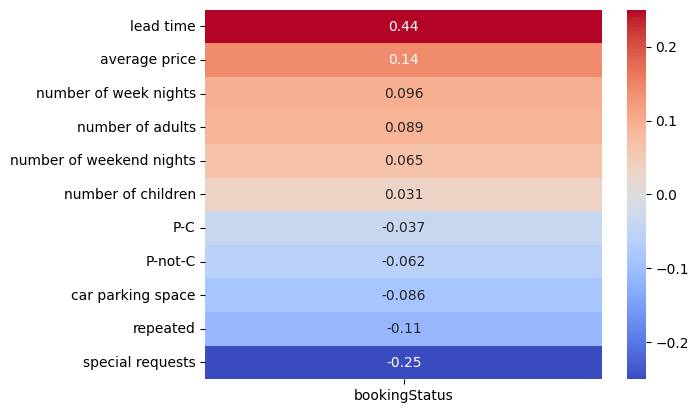

In [255]:
# create a visual to show the correaltions between the features and the target variable

corrMatrix = eda_test_data.corr(numeric_only = True).sort_values(by = 'bookingStatus', ascending = False)

corrMatrixWithoutStatus = corrMatrix.drop('bookingStatus')

sns.heatmap(corrMatrixWithoutStatus[['bookingStatus']], annot = True, cmap = 'coolwarm', vmax = 0.25, vmin = -0.25)


Clearly, the number of children and the amount of previous cancellations by the customer are not too directly correlated with predicting cancellation. However, as many of the other features are within the same range of correlation, we will not remove any of the features at the moment.

In [209]:
# look into any missing values (if there exists any)

new_X_train.isnull().sum().sum()

np.int64(0)

In [253]:
# check for missing values in the training set

new_X_train.isnull().sum()

Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
dtype: int64

In [ ]:
# use a simple imputer to fill in the missing values, based on the most common frequent value in the column

simple_imputer = SimpleImputer(strategy = 'most_frequent')

X_train_imputed = simple_imputer.fit_transform(new_X_train)
X_test_imputed = simple_imputer.fit_transform(new_X_test)

X_train_imputed_df = pd.DataFrame(X_train_imputed, columns = new_X_train.columns)
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns = new_X_test.columns)

X_test_imputed_df.head()



,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation
0,INN23922,2,0,1,3,Meal Plan 1,0,Room_Type 4,23,Online,0,0,0,140.9,0,6/2/2018
1,INN36168,2,0,1,4,Meal Plan 1,0,Room_Type 1,18,Online,0,0,0,94.4,1,6/13/2018
2,INN10484,2,0,1,1,Meal Plan 1,0,Room_Type 1,35,Online,0,0,0,200.0,1,9/26/2017
3,INN26624,1,0,1,1,Meal Plan 1,0,Room_Type 1,0,Corporate,0,0,0,185.0,0,9/19/2018
4,INN12178,2,0,2,1,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,147.67,1,7/9/2018


#### To make sure that categorical features are included in our model, we will use one-hot encoding to incorporate them.

In [236]:
# Must encode all categorical features that are present in the data, not just the target variable

cat_cols_one_hot = ['type of meal', 'room type', 'market segment type']

new_one_hot_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

one_hot_encoded = new_one_hot_encoder.fit_transform(X_train_imputed_df[cat_cols_one_hot])
one_hot_encoded_test = new_one_hot_encoder.transform(X_test_imputed_df[cat_cols_one_hot])

In [237]:
one_hot_encoded_features = new_one_hot_encoder.get_feature_names_out()
one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoded_features, index=X_train_imputed_df.index)

one_hot_df_test = pd.DataFrame(one_hot_encoded_test, columns=one_hot_encoded_features, index=X_test_imputed_df.index)

X_train_no_cat = X_train_imputed_df.drop(columns= cat_cols_one_hot)
X_test_no_cat = X_test_imputed_df.drop(columns= cat_cols_one_hot)

# Concatenate the encoded categorical features back
X_train_final = pd.concat([X_train_no_cat, one_hot_df], axis=1)
X_test_final = pd.concat([X_test_no_cat, one_hot_df_test], axis=1)
X_test_final.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests,date of reservation,type of meal_Meal Plan 1,type of meal_Meal Plan 2,type of meal_Meal Plan 3,type of meal_Not Selected,room type_Room_Type 1,room type_Room_Type 2,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Aviation,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online
0,INN23922,2,0,1,3,0,23,0,0,0,140.9,0,6/2/2018,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,INN36168,2,0,1,4,0,18,0,0,0,94.4,1,6/13/2018,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,INN10484,2,0,1,1,0,35,0,0,0,200.0,1,9/26/2017,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,INN26624,1,0,1,1,0,0,0,0,0,185.0,0,9/19/2018,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,INN12178,2,0,2,1,0,1,0,0,0,147.67,1,7/9/2018,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# date of reservation does not add any value to the model, so we will drop it

X_train_final.drop(columns = ['date of reservation'], inplace = True)
X_test_final.drop(columns = ['date of reservation'], inplace = True)
X_test_final.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests,type of meal_Meal Plan 1,type of meal_Meal Plan 2,type of meal_Meal Plan 3,type of meal_Not Selected,room type_Room_Type 1,room type_Room_Type 2,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Aviation,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online
0,INN23922,2,0,1,3,0,23,0,0,0,140.9,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,INN36168,2,0,1,4,0,18,0,0,0,94.4,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,INN10484,2,0,1,1,0,35,0,0,0,200.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,INN26624,1,0,1,1,0,0,0,0,0,185.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,INN12178,2,0,2,1,0,1,0,0,0,147.67,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [228]:
# do a little bit of research into the dummy variable trap and whether our dataset suffers from it as a result of one-hot encoding

# first, convert all columns to ints or floats as they are currently in object format
for col in X_train_final.columns[:17]:
    X_train_final[col] = pd.to_numeric(X_train_final[col], errors='coerce')

for col in X_train_final.columns[:17]:
    non_numeric = X_train_final[~X_train_final[col].apply(lambda x: isinstance(x, (int, float)))]
    if not non_numeric.empty:
        print(f"Issues in column {col}:")
        print(non_numeric)

def calculate_vif(dataframe):
    df_with_constant = add_constant(dataframe)

    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_with_constant.columns
    vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]

    return vif_data

vif_df = calculate_vif(X_train_final)
vif_df


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,number of adults,1.343483
2,number of children,2.040940
3,number of weekend nights,1.065109
4,number of week nights,1.095308
5,car parking space,1.037799
6,lead time,1.213903
7,repeated,1.779614
8,P-C,1.361021
9,P-not-C,1.640292


In [ ]:
# clear presence of the dummy variable trap, so we will remove some of the one-hot encoded features, also drop the column with target variable

X_train_final = X_train_final.drop(columns=['room type_Room_Type 1', 'type of meal_Meal Plan 1', 'market segment type_Aviation'])



,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests,type of meal_Meal Plan 2,type of meal_Meal Plan 3,type of meal_Not Selected,room type_Room_Type 2,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online
0,1,0,2,1,0,11,0,0,0,62.37,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,0,2,1,0,122,0,0,0,107.00,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,0,0,3,1,78,0,0,0,105.30,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,0,0,2,0,132,0,0,0,153.00,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2,0,0,1,0,16,0,0,0,75.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [232]:
vif_df = calculate_vif(X_train_final)
vif_df

,Feature,VIF
0,const,311.308765
1,number of adults,1.343483
2,number of children,2.040940
3,number of weekend nights,1.065109
4,number of week nights,1.095308
5,car parking space,1.037799
6,lead time,1.213903
7,repeated,1.779614
8,P-C,1.361021
9,P-not-C,1.640292


In [242]:
# perform the same mitigation measures for the test set

X_test_final.drop(columns = ['Booking_ID'], inplace = True)

for col in X_test_final.columns[:17]:
    X_test_final[col] = pd.to_numeric(X_test_final[col], errors='coerce')

for col in X_test_final.columns[:17]:
    non_numeric = X_test_final[~X_test_final[col].apply(lambda x: isinstance(x, (int, float)))]
    if not non_numeric.empty:
        print(f"Issues in column {col}:")
        print(non_numeric)

vif_df = calculate_vif(X_test_final)

vif_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Feature,VIF
0,const,0.000000
1,number of adults,1.314491
2,number of children,1.842431
3,number of weekend nights,1.072604
4,number of week nights,1.101677
5,car parking space,1.029978
6,lead time,1.224913
7,repeated,1.695313
8,P-C,1.351523
9,P-not-C,1.526439


In [ ]:
X_test_final.drop(columns = ["type of meal_Meal Plan 1", "room type_Room_Type 1", "market segment type_Aviation"], inplace = True)
vif_df = calculate_vif(X_test_final)

vif_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Feature,VIF
0,const,324.640915
1,number of adults,1.314491
2,number of children,1.842431
3,number of weekend nights,1.072604
4,number of week nights,1.101677
5,car parking space,1.029978
6,lead time,1.224913
7,repeated,1.695313
8,P-C,1.351523
9,P-not-C,1.526439


## Model Training and Testing

In [233]:
# dummy trap has been mitigated against, now let's train the model

rf = RandomForestClassifier()

rf.fit(X_train_final, new_y_train)

RandomForestClassifier()

In [248]:
y_pred = rf.predict(X_test_final)

In [249]:
accuracy = accuracy_score(new_y_test, y_pred)
print(accuracy)

0.8881080336227091


In [251]:
print("Confusion Matrix: ")
print(confusion_matrix(new_y_test, y_pred))

print("Classification Report: ")
print(classification_report(new_y_test, y_pred, digits = 4))

y_proba = rf.predict_proba(X_test_final)[:,1]
roc_auc = roc_auc_score(new_y_test, y_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

Confusion Matrix: 
[[4565  314]
 [ 498 1880]]
Classification Report: 
              precision    recall  f1-score   support

           0     0.9016    0.9356    0.9183      4879
           1     0.8569    0.7906    0.8224      2378

    accuracy                         0.8881      7257
   macro avg     0.8793    0.8631    0.8704      7257
weighted avg     0.8870    0.8881    0.8869      7257


ROC-AUC Score: 0.9450


Let's interpret the results.

4565 true negatives were predicted, and 1880 true positives were predicted. 314 false psotiives were outputted and 498 false negatives were predicted. The slightly better perforamnce when it comes to predicting negatives can be explaiend by the slightly imbalanced distribution of positive and negative classes (67% of classes were negative).

Out of all predicted non-cancellations, 90% were correctly identiifed. Out of all correct non-cancellations, around 93.5% were identified. The f1-score is the harmonic mean of precision and recall, which is 0.9183.

Out of all predicted cancellations, the model predicted close to 86% accurately. Out of all correct cancellations, around 80% were predicted correctly. The f1-score as such was 0.8224. 

The ROC-AUC Score is 0.9450, suggesting the model has done very well in this binary classification task.